# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import filename_for

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
num_dp = 30
max_neutrons = 4
label = "nPH"

In [4]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.parquet")
    for n in range(1, max_neutrons + 1)
    for s in range(20)
]
dfs = [pd.read_parquet(file) for file in files]
data = pd.concat(dfs, ignore_index=True).sample(frac=1)
print(data.shape)

(800000, 6)


In [5]:
msk = np.random.rand(len(data)) < 0.8
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
msk[0] = True
data.loc[0] = [0, 0, 0, 0, 0, 0]
traindata = data[msk]
testdata = data[~msk]

print(traindata.shape)
print(testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(639917, 6)
(160083, 6)


In [6]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(
        x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2
    )
    print("----")

(SM)
Epoch 1/50
640/640 - 2s - loss: 91.8617 - accuracy: 0.2716 - val_loss: 12.8746 - val_accuracy: 0.2928
Epoch 2/50
640/640 - 1s - loss: 2.6941 - accuracy: 0.3611 - val_loss: 1.6027 - val_accuracy: 0.4144
Epoch 3/50
640/640 - 1s - loss: 1.2559 - accuracy: 0.4894 - val_loss: 1.0463 - val_accuracy: 0.5691
Epoch 4/50
640/640 - 1s - loss: 0.9867 - accuracy: 0.6219 - val_loss: 0.9443 - val_accuracy: 0.6629
Epoch 5/50
640/640 - 1s - loss: 0.9179 - accuracy: 0.6976 - val_loss: 0.8922 - val_accuracy: 0.6503
Epoch 6/50
640/640 - 1s - loss: 0.8697 - accuracy: 0.7173 - val_loss: 0.8463 - val_accuracy: 0.7882
Epoch 7/50
640/640 - 1s - loss: 0.8280 - accuracy: 0.7315 - val_loss: 0.8049 - val_accuracy: 0.7627
Epoch 8/50
640/640 - 1s - loss: 0.7917 - accuracy: 0.7407 - val_loss: 0.7713 - val_accuracy: 0.7678
Epoch 9/50
640/640 - 1s - loss: 0.7585 - accuracy: 0.7588 - val_loss: 0.7449 - val_accuracy: 0.7284
Epoch 10/50
640/640 - 1s - loss: 0.7313 - accuracy: 0.7596 - val_loss: 0.7174 - val_accuracy:

In [7]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

for name, model in models.items():
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(name, bac)

(SM) 0.821754880036535
(10, SM) 0.8104307768394964
(20, SM) 0.8234372967109836
(100, SM) 0.8245711681533514
(100, 10, SM) 0.8160140767648819


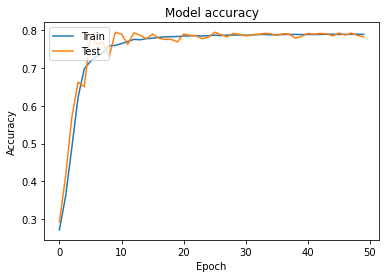

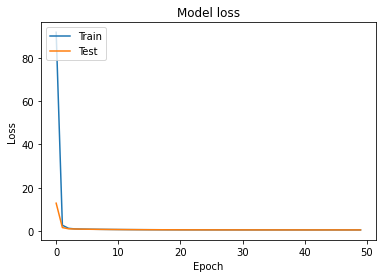

In [8]:
history = histories["(SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [10]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = models["(20, SM)"].predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1), normalize="true")
print(cmrel)

0.8234372967109836
[[ 2078     1     1     0     1]
 [    0 40226  2159    20     9]
 [    0  4752 29277  7615    15]
 [    0   200  5452 29096  6278]
 [    0     6   361  7588 24948]]
[[0.999 0.    0.    0.    0.   ]
 [0.    0.948 0.051 0.    0.   ]
 [0.    0.114 0.703 0.183 0.   ]
 [0.    0.005 0.133 0.709 0.153]
 [0.    0.    0.011 0.231 0.758]]
